## Instant Ramen Ratings
### Tidying with Pandas // Visualization with Seaborn
  
Just a fun little dataset I found on Kaggle.  
Instant ramen reviews from around the world including:  
* Star rating out of 5
* Brand and product names
* Style (cup, packet, bowl, etc.)
* Country (of the reviewer)
* Top Ten (any annual top ten title received by the product,, if applicable)
  
The data is a bit messy, giving me a chance to do a quick demonstration of the tidying process in python, along with preliminary analysis and visualization.  

### Read in and look over the data
---

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('ramen-ratings.csv')
df.head()

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
0,2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,NaN
1,2579,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1,NaN
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,NaN
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,NaN
4,2576,Ching's Secret,Singapore Curry,Pack,India,3.75,NaN


In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 7 columns):
Review #    2580 non-null int64
Brand       2580 non-null object
Variety     2580 non-null object
Style       2578 non-null object
Country     2580 non-null object
Stars       2580 non-null object
Top Ten     41 non-null object
dtypes: int64(1), object(6)
memory usage: 141.2+ KB


Maybe 2 values missing for 'style'. Need to check out Top Ten to see why we have 41 non-null values and not some multiple of 10

In [105]:
df.apply(lambda x: len(x.unique()))

Review #    2580
Brand        355
Variety     2413
Style          8
Country       38
Stars         51
Top Ten       39
dtype: int64

Notes:
* 2580 total reviews, nearly as many different varieties. It looks like 'variety' just refers to the name on the package. 
* 8 styles, could be a good metric to look at.
* 51 different rating values (I assume 1~5). We can treat this variable as numeric

### Tidying
---

#### 'Top Ten' Column

In [106]:
df['Top Ten'].unique()

array([nan, '2016 #10', '2016 #1', '2016 #8', '2016 #5', '2016 #9',
       '2016 #7', '2015 #10', '2015 #7', '2015 #4', '2015 #9', '2015 #6',
       '2015 #1', '2013 #10', '2015 #8', '2014 #7', '2014 #4', '2014 #9',
       '2014 #10', '2014 #8', '2014 #5', '2014 #6', '2014 #1', '2013 #1',
       '2013 #2', '2013 #4', '\n', '2013 #9', '2013 #3', '2012 #10',
       '2012 #7', '2012 #5', '2012 #3', '2012 #6', '2012 #9', '2012 #1',
       '2012 #2', '2013 #6', '2012 #4'], dtype=object)

OK so we have #s 1, 5, 8, 9, 10 for 2016, 7 values for 2015, .... kind of a mess tbh.  
I will keep this column, though I think I'll just make it a logical variable (True/1 if it made the top ten list at some point, False/0 if it hasn't), cuz it's not like I have dates for any of the other reviews anyway

Also imma go ahead and change out the column names cuz they'll surely bug me down the line.

In [107]:
# Rename cols
df = df.rename(columns={'Review #': 'Review_ID', 'Top Ten': 'Year_Top_Ten'})

In [108]:
# Modify Top_Ten column
df.Year_Top_Ten.replace('\n', False, inplace=True)
df.Year_Top_Ten.fillna(False, inplace=True)
df.Year_Top_Ten.where(df.Year_Top_Ten==0, other=True, inplace=True)

In [109]:
df.Year_Top_Ten.value_counts()

False    2543
True       37
Name: Year_Top_Ten, dtype: int64

---
#### 'Stars'
And let's change 'stars' to numeric values

In [110]:
df.Stars.unique()

array(['3.75', '1', '2.25', '2.75', '4.75', '4', '0.25', '2.5', '5',
       '4.25', '4.5', '3.5', 'Unrated', '1.5', '3.25', '2', '0', '3',
       '0.5', '4.00', '5.0', '3.50', '3.8', '4.3', '2.3', '5.00', '3.3',
       '4.0', '3.00', '1.75', '3.0', '4.50', '0.75', '1.25', '1.1', '2.1',
       '0.9', '3.1', '4.125', '3.125', '2.125', '2.9', '0.1', '2.8', '3.7',
       '3.4', '3.6', '2.85', '3.2', '3.65', '1.8'], dtype=object)

There is at least one 'unrated' row. We'll drop any unrated rows since any ratingless ramen won't help us look at what affects ratings in the slightest.

In [111]:
# df.Stars.value_counts()
# Turns out there are just 3 unrated entries

In [112]:
# Drop Unrated rows
df = df[df.Stars != 'Unrated']

In [113]:
# And convert star ratings  to float
df.Stars = df.Stars.astype(float)
df.Stars.dtype

dtype('float64')

---
#### 'Style' missing values

Next we'll look at the potential nulls in style, assuming they weren't just dropped.

In [114]:
df.Style.unique()

array(['Cup', 'Pack', 'Tray', 'Bowl', 'Box', 'Can', 'Bar', nan], dtype=object)

In [115]:
df[df.Style.isnull()]

,Review_ID,Brand,Variety,Style,Country,Stars,Year_Top_Ten
2152,428,Kamfen,E Menm Chicken,NaN,China,3.75,False
2442,138,Unif,100 Furong Shrimp,NaN,Taiwan,3.00,False


Ok nothing particularly out of the ordinary. The Style value was likely just not included in the review. I'm actually surprised there are so few nulls in this data. Anyway let's see if we can impute these nulls wisely..  
To start we'll see if we have any more rows with the same brand/variety.

In [116]:
df[(df.Variety == 'E Menm Chicken') | (df.Variety == '100 Furong Shrimp')]

,Review_ID,Brand,Variety,Style,Country,Stars,Year_Top_Ten
2152,428,Kamfen,E Menm Chicken,NaN,China,3.75,False
2442,138,Unif,100 Furong Shrimp,NaN,Taiwan,3.00,False


Nope on variety, just these two.

In [117]:
df[(df.Brand == 'Kamfen') | (df.Brand == 'Unif')]

,Review_ID,Brand,Variety,Style,Country,Stars,Year_Top_Ten
223,2357,Kamfen,Noodle King Artificial Wonton Soup Flavored,Bowl,Hong Kong,5.00,False
294,2286,Kamfen,Noodle King Artificial Abalone And Chicken Sou...,Bowl,Hong Kong,4.00,False
322,2258,Kamfen,Instant Wonton Noodles Scallop Lobster Soup Fl...,Bowl,Hong Kong,4.30,False
519,2061,Kamfen,Dried Mix Noodles Scallop Seafood Flavoured,Tray,Hong Kong,4.25,False
548,2032,Kamfen,Noodle King Artificial Beef Soup Flavored,Bowl,Hong Kong,3.75,False
574,2006,Kamfen,Wonton Noodles Beef Flavour,Bowl,Hong Kong,3.75,False
1253,1327,Unif,Unif-100 Instant Noodles Artificial Tart Beef ...,Pack,China,3.00,False
1336,1244,Unif,Unif-100 Pickled Cayenne Flavor Beef Ramen,Pack,China,3.75,False
1414,1166,Unif,Man Han Feast Sichuan Chilli Eel Flavor,Bowl,Taiwan,5.00,False
1447,1133,Kamfen,E-Men Noodles Abalone Soup Flavor,Pack,Hong Kong,3.75,False


OK so we have some results to work with here.
Let's try to narrow our comparisons a bit:

In [118]:
df[(df.Brand == 'Kamfen') & (df.Country == 'China')]

,Review_ID,Brand,Variety,Style,Country,Stars,Year_Top_Ten
1638,942,Kamfen,E-men Lobster Soup,Pack,China,3.25,False
1649,931,Kamfen,dried Mix Noodles Soya Bean Paste,Tray,China,3.75,False
1652,928,Kamfen,Dried Mix Noodles Artificial Spicy Pork,Tray,China,4.00,False
2094,486,Kamfen,Japanese U-Don Lobster Scallop,Pack,China,3.00,False
2152,428,Kamfen,E Menm Chicken,NaN,China,3.75,False
2187,393,Kamfen,Dried Mix Noodles XO Sauce,Tray,China,2.00,False
2399,181,Kamfen,Noodle King Thin Wonton,Pack,China,2.00,False
2441,139,Kamfen,Noodle King Beef,Pack,China,1.75,False


Hmm.. so almost certainly 'Tray' or 'Pack', but hard to say which. Just because of the higher rating I'm tempted to say Tray.  
Let's look at the Unif NaN then:

In [119]:
df[(df.Brand == 'Unif') & (df.Country == 'Taiwan')]

,Review_ID,Brand,Variety,Style,Country,Stars,Year_Top_Ten
1414,1166,Unif,Man Han Feast Sichuan Chilli Eel Flavor,Bowl,Taiwan,5.00,False
1874,706,Unif,Man Han Feast Spring Onion Eel,Bowl,Taiwan,4.25,False
2144,436,Unif,Artificial Beef With Sauerkraut,Bowl,Taiwan,3.75,False
2258,322,Unif,Shrimp Fish,Bowl,Taiwan,3.75,False
2262,318,Unif,Super Bowl Artificial Pickled Chilli Beef,Bowl,Taiwan,3.25,False
2264,316,Unif,Super Bowl Artificial Stewed Pork Chop,Bowl,Taiwan,3.50,False
2265,315,Unif,Super Bowl Artificial Spicy Beef,Bowl,Taiwan,2.75,False
2331,249,Unif,100 Artificial Spicy Beef,Pack,Taiwan,3.75,False
2442,138,Unif,100 Furong Shrimp,NaN,Taiwan,3.00,False
2449,131,Unif,100 Artificial Shallot Chicken,Pack,Taiwan,3.25,False


Alright cool, so the mode for Style here is overwhelmingly 'Bowl', so that's what we'll replace the null with.  
And I'll also replace the Kamfen null with 'Tray' so we're not left with a single null value in our data. Do note however that if we had a greater number of nulls, the imputation of which would have a more than negligable impact on our Style distribution, I would be much more hesitant to choose 'Tray' with so little certainty.  
But in this case the one value won't make a difference and it's not worth further consideration (plus it is my best, educated guess givent the information available).

In [120]:
df.loc[df.Variety == 'E Menm Chicken', 'Style'] = 'Tray' 
df.loc[df.Variety == '100 Furong Shrimp', 'Style'] = 'Bowl'
df.Style.unique()

array(['Cup', 'Pack', 'Tray', 'Bowl', 'Box', 'Can', 'Bar'], dtype=object)

---
#### Ok so we've dealt with some null values and data types.  
#### Next let's look at univariate distributions in a little more detail
---

#### 'Brand'

In [121]:
df.Brand.value_counts()

Nissin                    381
Nongshim                   98
Maruchan                   76
Mama                       71
Paldo                      66
Myojo                      63
Indomie                    53
Samyang Foods              51
Ottogi                     45
Lucky Me!                  34
Vina Acecook               34
Vifon                      33
Maggi                      30
Mamee                      29
Master Kong                28
MAMA                       27
A-Sha Dry Noodle           26
Wai Wai                    25
KOKA                       25
Sapporo Ichiban            25
MyKuali                    24
Ve Wong                    24
JML                        23
Samyang                    19
Koka                       18
Batchelors                 16
Doll                       16
Kamfen                     15
Mr. Noodles                15
Wei Lih                    15
                         ... 
Yum-Mie                     1
Osaka Ramen                 1
Unzen     

So we have a lot of brands with only one entry.  
This is not a problem. We want to consider the Style and Country variables as well in our analysis of what impacts rating, so we wouldn't want to get rid of Brands with only 1 or 2 ratings.  
However we might want to look at a sample of the most often rated brands at some point.

In [122]:
# For instance:
top_freq_brands = df.groupby(['Brand'])['Brand'].agg({'Brand_count': len}).sort_values('Brand_count', ascending=False).head(10).reset_index()
top_freq_brands

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,Brand,Brand_count
0,Nissin,381
1,Nongshim,98
2,Maruchan,76
3,Mama,71
4,Paldo,66
5,Myojo,63
6,Indomie,53
7,Samyang Foods,51
8,Ottogi,45
9,Vina Acecook,34


In [123]:
# create a subset of df with just the top 10 frequently rated brands
df_freq_brands = df[df.Brand.isin(top_freq_brands.Brand)]
df_freq_brands.shape

(938, 7)

And why not take a look at the top brands while we're at it

In [124]:
#df_freq_brands.boxplot(column='Stars', by='Brand')
#plt.xticks(rotation=30)
#plt.show()

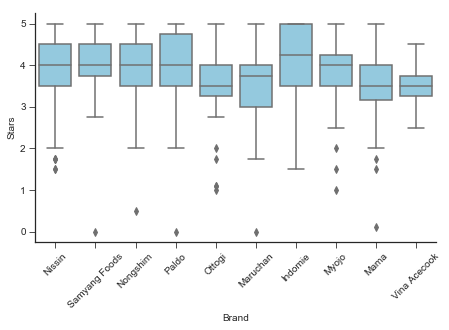

In [125]:
with sns.axes_style(style='ticks'):
    bbox = sns.factorplot('Brand', 'Stars', data=df_freq_brands, kind='box', color='skyblue', aspect=1.6)
    bbox.set_xticklabels(rotation=45)
    plt.show()

---
#### 'Style' visualization

We've already looked at style a little bit, but let's visualize the distributions of our unique variables

In [126]:
df.Style.value_counts()

Pack    1528
Bowl     482
Cup      450
Tray     109
Box        6
Bar        1
Can        1
Name: Style, dtype: int64

In [127]:
#df.boxplot(column='Stars', by='Style')
#plt.show()

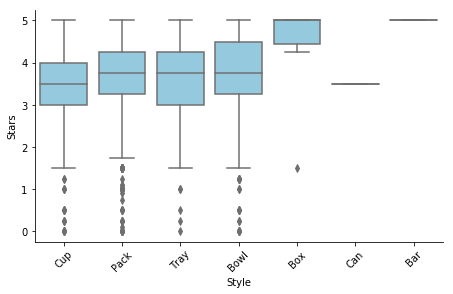

In [128]:
sbox = sns.factorplot('Style', 'Stars', data=df, kind='box', color='skyblue', aspect=1.6)
sbox.set_xticklabels(rotation=45)
plt.show()

So we have just one occurance each of 'Bar' and 'Can' ramen, and only 6 of 'Box'.  
I'm not even sure what 'bar' ramen is.. I mean I've eaten in plenty of 'ramen bars' but I get the feeling that's not the case here ..  
Might as well take a look:

In [129]:
df[(df.Style == 'Bar') | (df.Style == 'Can')]

,Review_ID,Brand,Variety,Style,Country,Stars,Year_Top_Ten
67,2513,Pringles,Nissin Top Ramen Chicken Flavor Potato Crisps,Can,USA,3.5,False
1425,1155,Komforte Chockolates,Savory Ramen,Bar,USA,5.0,False


Ah okay so these aren't even ramen.  
I have to say my interest is piqued by the second row above haha  
Is that 5-star-rated ramen-flavored chocolate?? (0_0)  
  
But in all seriousness, we'll drop these rows.

In [130]:
df.drop([67, 1425], inplace=True)


In [131]:
# Looking at 'Box' styles
df[df.Style == 'Box']

,Review_ID,Brand,Variety,Style,Country,Stars,Year_Top_Ten
36,2544,Lipton,Cup-A-Soup Chicken Noodle With White Meat Inst...,Box,USA,1.50,False
80,2500,The Ramen Rater Select,Supreme Creamy Tom Yum Noodle,Box,Malaysia,5.00,False
139,2441,MyKuali,Penang Hokkien Prawn Flavor Noodle,Box,Japan,5.00,False
161,2419,MyKuali,Penang Red Tom Yum Goong,Box,Japan,5.00,False
203,2377,MyKuali,Penang White Curry Instant Noodle (Japan Version),Box,Malaysia,5.00,False
1471,1109,La Fonte,Spaghetti With Bolognese Sauce,Box,Indonesia,4.25,False


Apparently ramen holds a very broad definition when it comes to this dataset.  
I guess we'll count any noodles as ramen lol   
Anyway, by looking at the original 'BIG LIST' on the ramenrater website, these do appear to be packaged in box form, and may just be their own category.  
We'll leave these values untouched for now.  

In [132]:
df.Style.value_counts()

Pack    1528
Bowl     482
Cup      450
Tray     109
Box        6
Name: Style, dtype: int64

In [133]:
# Let's just look once again
#df.boxplot(column='Stars', by='Style')
#plt.show()

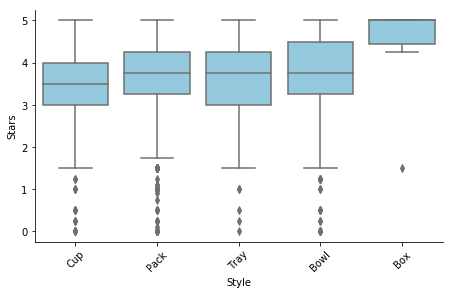

In [134]:
sbox = sns.factorplot('Style', 'Stars', data=df, kind='box', color='skyblue', aspect=1.6)
sbox.set_xticklabels(rotation=45)
plt.show()

* So Box is skewed due to the very few values it contains. For some of the coming visualization I will disinclude the box category in order to more clearly show overall trends and emphasize the other factors.  
* Bowl is relatively popular it seems.  
* Cup maybe not so much, but Cup also has more values than all the other Styles combined, so not shocking.  

---
#### 'Country'

In [135]:
df.Country.value_counts()

Japan            352
USA              321
South Korea      307
Taiwan           224
Thailand         191
China            169
Malaysia         155
Hong Kong        137
Indonesia        126
Singapore        109
Vietnam          108
UK                69
Philippines       47
Canada            41
India             31
Germany           27
Mexico            25
Australia         22
Netherlands       15
Nepal             14
Myanmar           14
Hungary            9
Pakistan           9
Bangladesh         7
Colombia           6
Brazil             5
Cambodia           5
Fiji               4
Poland             4
Holland            4
Dubai              3
Finland            3
Sweden             3
Sarawak            3
Estonia            2
Ghana              2
Nigeria            1
United States      1
Name: Country, dtype: int64

kk first of all let's change the one 'United States' to 'USA', 'Sarawak' to 'Malaysia', 'Holland' to 'Netherlands', and 'Dubai' to 'UAE', for consistency

In [136]:
# United States --> USA
df.loc[df.Country == 'United States', 'Country'] = 'USA'
df.loc[df.Country == 'Sarawak', 'Country'] = 'Malaysia'
df.loc[df.Country == 'Holland', 'Country'] = 'Netherlands'
df.loc[df.Country == 'Dubai', 'Country'] = 'UAE'
print(any(df.Country == 'United States'), any(df.Country == 'Sarawak'), any(df.Country == 'Holland'), any(df.Country == 'Dubai'))

False False False False


In [137]:
top_freq_countries = df.groupby(['Country'])['Country'].agg({'Country_count': len}).sort_values('Country_count', ascending=False).head(11).reset_index()
top_freq_countries

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,Country,Country_count
0,Japan,352
1,USA,322
2,South Korea,307
3,Taiwan,224
4,Thailand,191
5,China,169
6,Malaysia,158
7,Hong Kong,137
8,Indonesia,126
9,Singapore,109


In [138]:
df_freq_countries = df[df.Country.isin(top_freq_countries.Country)]
df_freq_countries.shape

(2203, 7)

In [139]:
# And boxplot for top 11 countries (11, because #10 Singapore and #11 Vietnam are so close in frequency,
# followed by a gap between #11 Vietnam and #12 UK), like we did with Brands
#df_freq_countries.boxplot(column='Stars', by='Country')
#plt.xticks(rotation=45)
#plt.show()

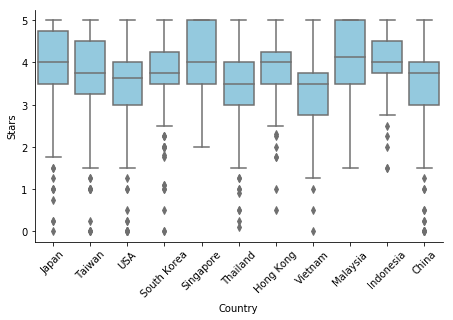

In [140]:
cbox = sns.factorplot('Country', 'Stars', data=df_freq_countries, kind='box', color='skyblue', aspect=1.6)
cbox.set_xticklabels(rotation=45)
plt.show()

Of course this is just to check for irregularities.  
We're not trying to measure how critical certain countries' citizenry are of packaged noodles.  
Variation is more likely due to the prooportions in which you can find different styles, etc. of ramen in different countries.   

---
#### 'Stars'
looking at the general distribution of our target variable

In [141]:
df.Stars.describe()

count    2575.000000
mean        3.654214
std         1.015374
min         0.000000
25%         3.250000
50%         3.750000
75%         4.250000
max         5.000000
Name: Stars, dtype: float64

In [142]:
#for i in range(10,40,10):
#    df.Stars.plot('hist', bins=i)
#    plt.show()

#df.Stars.plot('hist', bins=10)
##plt.show()
##df.Stars.plot('hist', bins=10)
#plt.show()
#df.Stars.plot('hist', bins=10)
#plt.show()

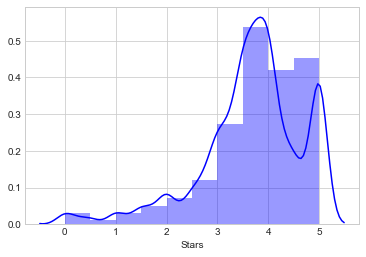

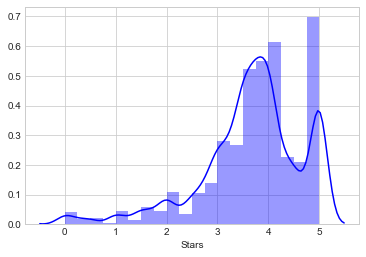

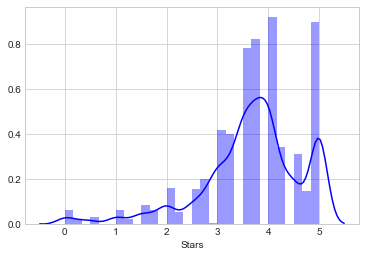

In [143]:
with sns.axes_style(style='whitegrid'):
    sns.distplot(df['Stars'], bins=10, color='blue')
    plt.show()
    sns.distplot(df['Stars'], bins=20, color='blue')
    plt.show()
    sns.distplot(df['Stars'], bins=30, color='blue')
    plt.show()

Left skew, relatively few ratings below 1, but that isn't surprising and I think something we want to definitely keep in the distribution.  
Mean around 3.65, seems fairly usual.  
A decent number of 5s, I imagine because the kind of people who go online to rate packaged ramen are kind of, you know, more into packaged ramen than the average person. For the most part they probably go into the experience with the understanding that it's not going to be like eating at a 5-star restaurant.  
Note the spikes at integer rating values. Evidence that humans are giving the ratings.  

---
OK for now I feel good that we have a clean dataset.  
We can move on to the meat of our visualization.  
I've actually already finished the coffee portion of this coffee break data viz (or I've finished the café au lait portion, rather) with all my rambling.  
I think this is good though. I've been able to show some tidying + my general process of overviewing a not-so-perfect dataset in addition to the visualization, which is just as if not more vital to the work of a data detective.  

Sorry, bit of rambling again. Let's continue..  

---
#### Bit of feature engineering: 'Region'

In [144]:
# For ref.
df.head()

,Review_ID,Brand,Variety,Style,Country,Stars,Year_Top_Ten
0,2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,False
1,2579,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1.00,False
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,False
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,False
4,2576,Ching's Secret,Singapore Curry,Pack,India,3.75,False


I'm actually gonna create a 'Region' column because it'll be difficult to compare everything by country.

In [145]:
df.Country.value_counts()

Japan          352
USA            322
South Korea    307
Taiwan         224
Thailand       191
China          169
Malaysia       158
Hong Kong      137
Indonesia      126
Singapore      109
Vietnam        108
UK              69
Philippines     47
Canada          41
India           31
Germany         27
Mexico          25
Australia       22
Netherlands     19
Myanmar         14
Nepal           14
Hungary          9
Pakistan         9
Bangladesh       7
Colombia         6
Brazil           5
Cambodia         5
Fiji             4
Poland           4
UAE              3
Finland          3
Sweden           3
Estonia          2
Ghana            2
Nigeria          1
Name: Country, dtype: int64

In [146]:
# Engineer 'Region' column
east_asia = ['Japan', 'South Korea', 'Taiwan', 'China', 'Hong Kong']
southeast_asia = ['Thailand', 'Malaysia', 'Indonesia', 'Singapore', 'Vietnam', 'Philippines', 'Myanmar', 'Cambodia']
south_asia = ['India', 'Nepal', 'Pakistan', 'Bangladesh']
oceania = ['Australia', 'Fiji']
mideast_africa = ['UAE', 'Ghana', 'Nigeria']
europe = ['UK', 'Germany', 'Netherlands', 'Hungary', 'Poland', 'Sweden','Finland', 'Estonia']
americas = ['USA', 'Canada', 'Mexico', 'Brazil', 'Colombia']

conditions = [
    df.Country.isin(east_asia),
    df.Country.isin(southeast_asia),
    df.Country.isin(south_asia),
    df.Country.isin(oceania),
    df.Country.isin(mideast_africa),
    df.Country.isin(europe),
    df.Country.isin(americas)
]
choices = ['East Asia', 'SE Asia', 'South Asia', 'Oceania', 'MidEast / Africa', 'Europe', 'Americas']

df['Region'] = np.select(conditions, choices)

df.head()

,Review_ID,Brand,Variety,Style,Country,Stars,Year_Top_Ten,Region
0,2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,False,East Asia
1,2579,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1.00,False,East Asia
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,False,Americas
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,False,East Asia
4,2576,Ching's Secret,Singapore Curry,Pack,India,3.75,False,South Asia


---
### A Taste of Seaborn Viz
---

In addition to the above. I usually just use base matplotlib aesthetics when doing preliminary exploration of the data, but today I switched to seaborn for a slightly more ap ('aesthetically pleasing') presentation.  

Let's look at some intervariate relationships

##### Region and Style

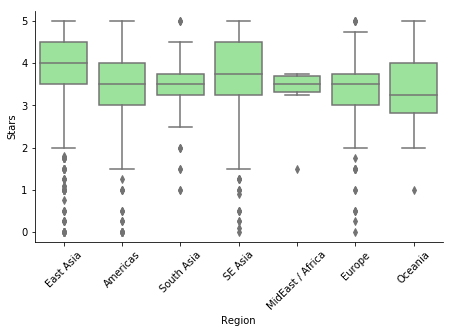

In [147]:
# Let's look at regions, first of all
rbox = sns.factorplot('Region', 'Stars', data=df, kind='box', color='lightgreen', aspect=1.6)
rbox.set_xticklabels(rotation=45)
plt.show()

Okay nothing to complain about.  
We know that MidEast/Africa includes relatively few data points.  

In [148]:
# As mentioned before, for now removing the 6-row 'Box' category of Style.
df = df[df.Style != 'Box']

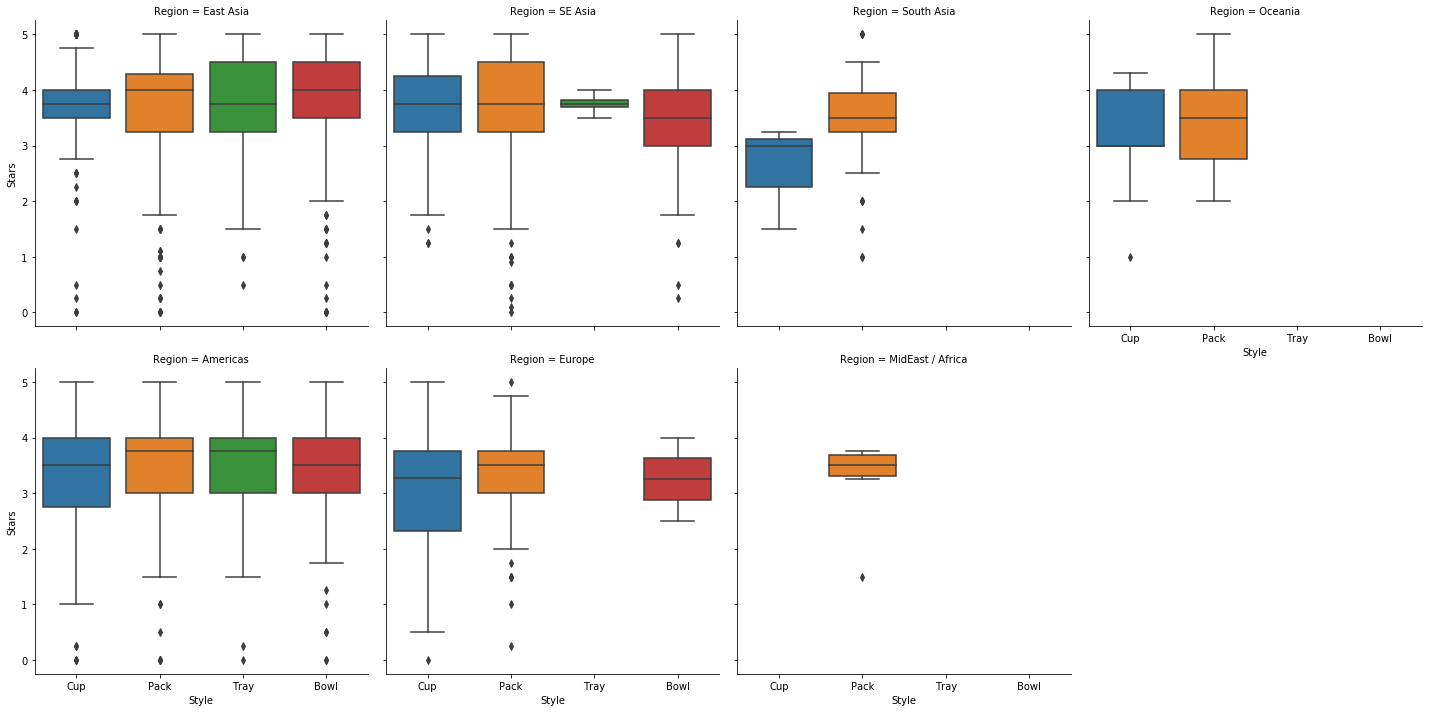

In [149]:
# Region + Style
regions_order = ['East Asia', 'SE Asia', 'South Asia', 'Oceania', 'Americas', 'Europe', 'MidEast / Africa']
sns.factorplot('Style', 'Stars', col='Region', data=df, kind='box', col_wrap=4, size=5, col_order=regions_order)
plt.show()

##### As violin plot

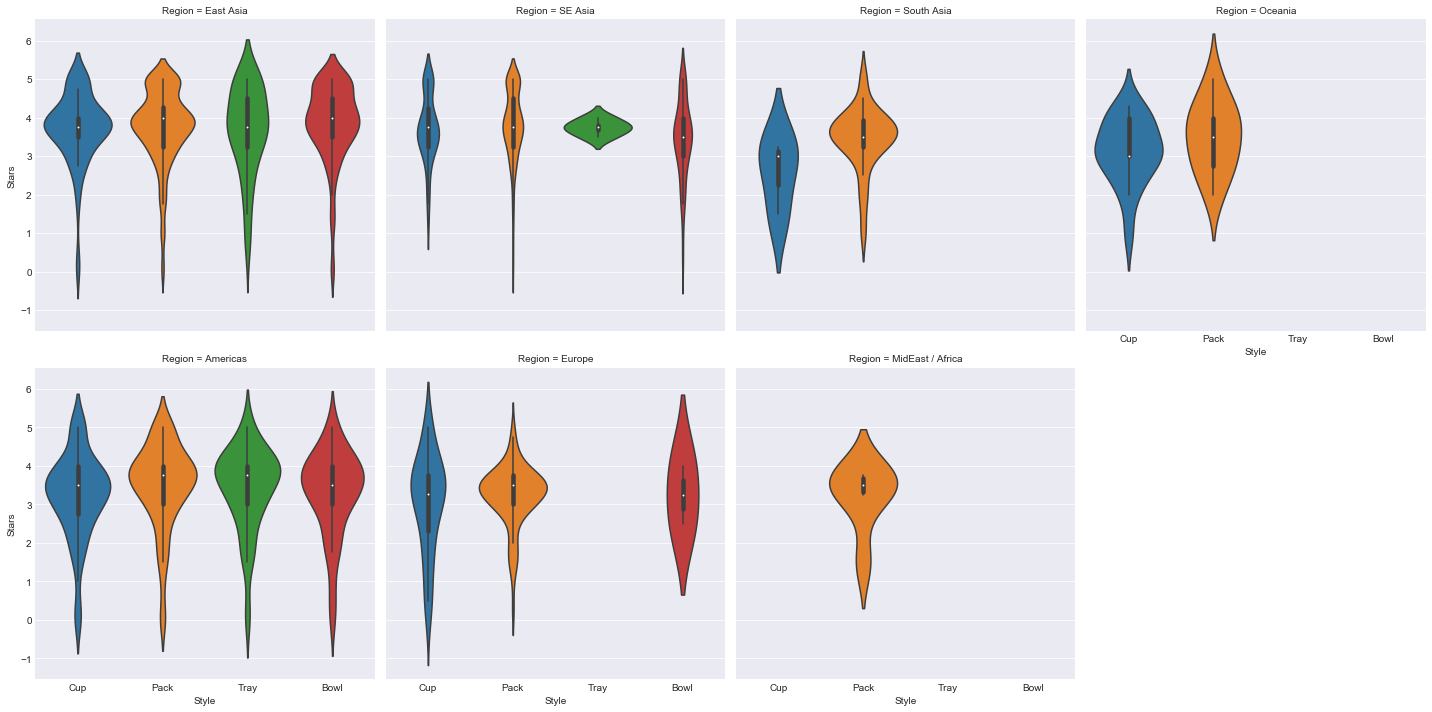

In [150]:
with sns.axes_style(style='darkgrid'):
    sns.factorplot('Style', 'Stars', col='Region', data=df, kind='violin', col_wrap=4, size=5, col_order=regions_order)
    plt.show()

Likewise we could do the inverse, facetting by Style:

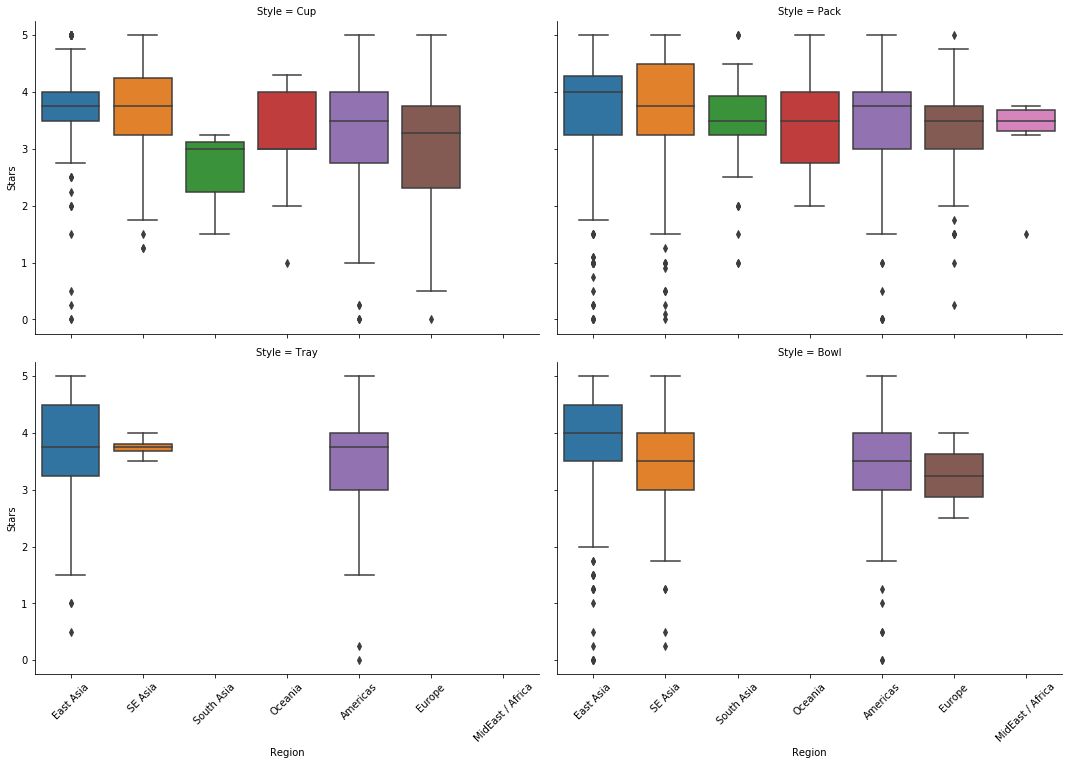

In [151]:
# Style + Region
g = sns.factorplot('Region', 'Stars', col='Style', data=df, kind='box', col_wrap=2, size=5, aspect=1.5, order=regions_order)
g.set_xticklabels(rotation=45)
plt.show()

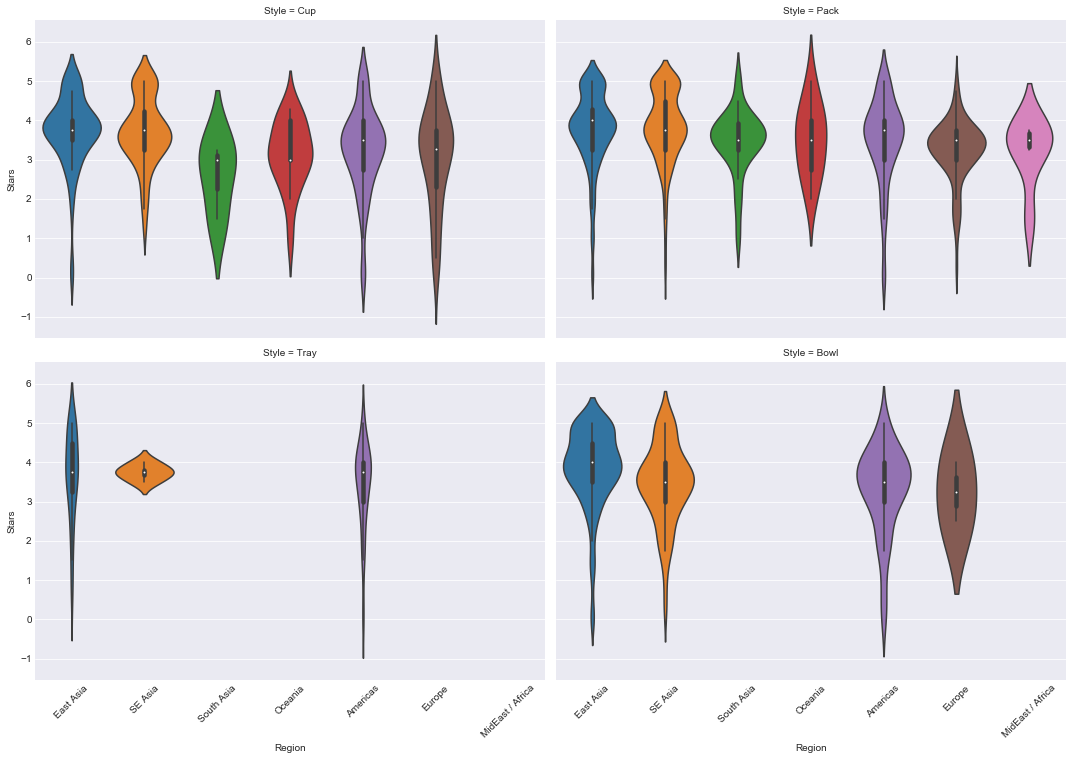

In [152]:
# violin plot version
with sns.axes_style(style='darkgrid'):
    g = sns.factorplot('Region', 'Stars', col='Style', data=df, kind='violin', col_wrap=2, size=5, aspect=1.5, order=regions_order)
    g.set_xticklabels(rotation=45)
    plt.show()

---
#### Binational comparison
Comparing for a minute, just Japan and the U.S.

In [153]:
df_jpn_us = df[(df.Country == 'Japan') | (df.Country == 'USA')]
df_jpn_us.head()

,Review_ID,Brand,Variety,Style,Country,Stars,Year_Top_Ten,Region
0,2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,False,East Asia
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,False,Americas
6,2574,Acecook,Spice Deli Tantan Men With Cilantro,Cup,Japan,4.00,False,East Asia
7,2573,Ikeda Shoku,Nabeyaki Kitsune Udon,Tray,Japan,3.75,False,East Asia
8,2572,Ripe'n'Dry,Hokkaido Soy Sauce Ramen,Pack,Japan,0.25,False,East Asia


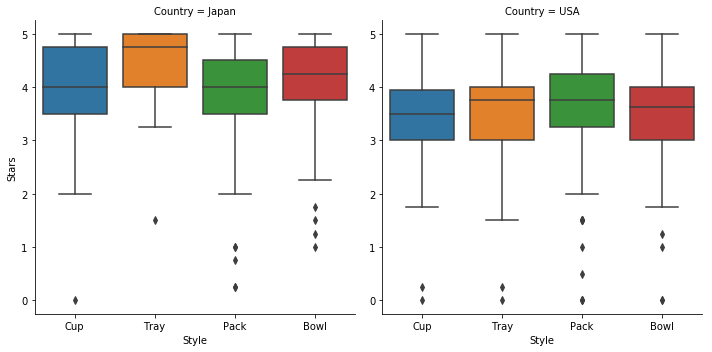

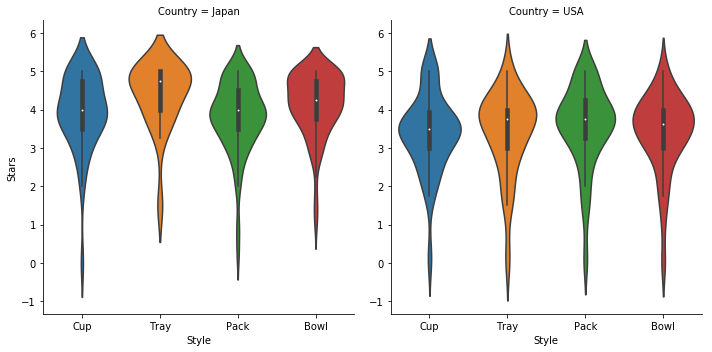

In [154]:
# Comparing Stars vs. Style for Japan and US
sns.factorplot('Style', 'Stars', col='Country', data=df_jpn_us, kind='box', size=5)
plt.show()
sns.factorplot('Style', 'Stars', col='Country', data=df_jpn_us, kind='violin', size=5)
plt.show()

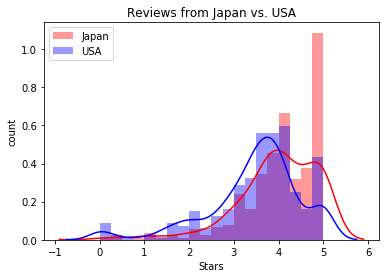

In [155]:
df_jpn = df[df.Country == 'Japan']
df_us = df[df.Country == 'USA']

sns.distplot(df_jpn['Stars'], bins=20, color='red', label='Japan')
sns.distplot(df_us['Stars'], bins=20, color='blue', label='USA')
plt.title('Reviews from Japan vs. USA')
plt.ylabel('count')
plt.legend()
plt.show()

Through these sorts of visualizations, we can compare reviewers from individual countries.  
For instance above, it looks like reviews in the U.S. are more likely to be critical than reviews coming from Japan, and Japan-originated reviews have a much higher chance of being 5 stars.